In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df_train = pd.read_pickle("../data/df_train.pkl")
df_test = pd.read_pickle("../data/df_test.pkl")

In [4]:
df_train_X = df_train.drop(columns = ["cleavage_freq"])
df_train_y = df_train["cleavage_freq"]

### Preprocessing

In [5]:
class Preprocessing:
    def fold_seq(df):
        df["stacked"] = df["grna_target_sequence"].apply(lambda x: x.tolist()) + df["target_sequence"].apply(lambda x: x.tolist())
        df["stacked"] = df["stacked"].apply(lambda x: np.array(x))
    
    def tensorfy(stacked):
        temp = []
        for i in stacked:
            temp.append(i)
        return torch.from_numpy(np.array(temp).astype(np.float32))

In [6]:
Preprocessing.fold_seq(df_train_X)
X = Preprocessing.tensorfy(df_train_X["stacked"])

In [7]:
#np.array(df_train_y).reshape(df_train_y.shape[0], 1)

In [8]:
y = torch.Tensor(np.array(df_train_y).reshape(df_train_y.shape[0], 1).astype(np.float32))

### Model

In [9]:
train_ds = TensorDataset(X, y)

In [10]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
#next(iter(train_dl))

In [11]:
model = nn.Linear(100, 1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.0898, -0.0735,  0.0236,  0.0410,  0.0598,  0.0471,  0.0864, -0.0884,
          0.0287,  0.0346,  0.0797,  0.0262, -0.0660, -0.0366, -0.0772, -0.0439,
          0.0304,  0.0832, -0.0618,  0.0259, -0.0810, -0.0845,  0.0171,  0.0321,
         -0.0076,  0.0309, -0.0988, -0.0443, -0.0736, -0.0583, -0.0778, -0.0644,
          0.0946, -0.0271,  0.0947, -0.0260,  0.0321,  0.0835, -0.0593,  0.0969,
         -0.0106,  0.0894, -0.0665,  0.0314, -0.0573, -0.0873,  0.0540,  0.0958,
         -0.0928,  0.0286, -0.0232, -0.0788,  0.0692, -0.0122, -0.0309,  0.0755,
         -0.0381,  0.0925,  0.0092, -0.0406, -0.0723, -0.0408, -0.0599, -0.0477,
         -0.0660,  0.0687,  0.0170,  0.0505,  0.0907,  0.0963, -0.0828,  0.0340,
          0.0746,  0.0786,  0.0422, -0.0148, -0.0381, -0.0459,  0.0535,  0.0623,
         -0.0251, -0.0411,  0.0826, -0.0016,  0.0057,  0.0213,  0.0488, -0.0814,
          0.0654, -0.0008, -0.0737, -0.0766, -0.0193, -0.0487,  0.0894,  0.0739,
      

In [12]:
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

In [13]:
loss_fn = F.mse_loss

In [14]:
loss = loss_fn(model(X), y)
print(loss)

tensor(0.1114, grad_fn=<MseLossBackward>)


In [15]:
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(X), y))

In [16]:
fit(100, model, loss_fn, opt)

Training loss:  tensor(0.0381, grad_fn=<MseLossBackward>)


In [17]:
preds = model(X)
preds

tensor([[ 0.0471],
        [ 0.0195],
        [-0.1581],
        ...,
        [ 0.1632],
        [ 0.0037],
        [ 0.0450]], grad_fn=<AddmmBackward>)

In [18]:
y

tensor([[7.0066e-05],
        [1.4500e-04],
        [5.1200e-04],
        ...,
        [1.0640e-03],
        [1.9703e-02],
        [2.3380e-06]])

In [19]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr


def benchmark(predictions, actuals):
    predictions = predictions.detach().numpy()
    actuals = actuals.detach().numpy()
    mse = mean_squared_error(y_true=actuals, y_pred=predictions)
    correlation, pvalue = spearmanr(a=actuals, b=predictions)

    return {
        'mean_squared_error': mse,
        'spearman_rank': {
            'correlation':  correlation,
            'pvalue': pvalue,
        }
    }

In [20]:
benchmark(preds, y)

{'mean_squared_error': 0.038078215,
 'spearman_rank': {'correlation': 0.1689672774176233,
  'pvalue': 8.89543999758166e-131}}

In [21]:
preds = preds.reshape(preds.shape[0],)
y = y.reshape(y.shape[0],)

In [22]:
preds = preds.detach().numpy()
y = y.detach().numpy()

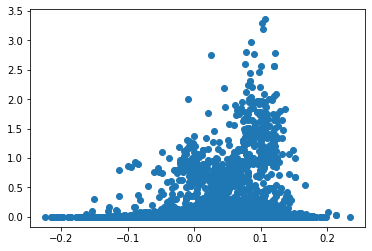

In [23]:
plt.scatter(preds, y)

In [24]:
v = pd.DataFrame(preds, columns = ["preds"])

In [25]:
v["y"] = y
v

,preds,y
0,0.047088,0.000070
1,0.019526,0.000145
2,-0.158123,0.000512
3,0.105560,0.000035
4,0.028963,0.000109
...,...,...
20438,0.023040,0.002479
20439,0.133620,0.000176
20440,0.163176,0.001064
20441,0.003651,0.019703


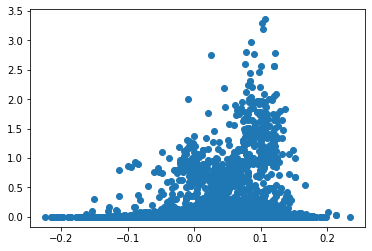

In [26]:
plt.scatter(v["preds"], v["y"])

In [27]:
v = v[v["y"] > 0.2]

In [28]:
v

,preds,y
16,0.070340,1.137556
33,0.122266,2.775273
86,0.094582,0.312305
163,0.107776,0.470600
166,0.016603,0.793148
...,...,...
20306,0.006159,0.666007
20330,0.072302,1.958181
20372,0.126680,1.340597
20388,0.003131,0.411203


In [29]:
y.shape

(20443,)

In [30]:
# 728/20443 ~ 3.6% of data high cleavage frequencies that model doesn't predict